In [15]:
from astropy import units as u
from astropy.coordinates import SkyCoord
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.integrate import quad
import multiprocessing as mp
import gc
import matplotlib.colors as colors
from matplotlib import rcParams 
from scipy.stats import gaussian_kde
from scipy.stats import binned_statistic_2d
from scipy import stats
import matplotlib.pyplot as plt
import astropy.coordinates as coord

In [2]:
plt.rc('font',size=25)
pd.set_option('max_column',200)

In [3]:
plt.rcParams.update({'figure.figsize': (6, 6),
                   'font.size':25,
                   'text.usetex':True,
                   'mathtext.default' : 'it',
                   'axes.labelsize': 32,
                   'legend.fontsize': 25,
                   'legend.fancybox': False,
                   'legend.numpoints': 1,
                   'xtick.labelsize': 32,
                   'ytick.labelsize': 32,
                   'ytick.major.width':0.8,
                   'ytick.major.size':8,
                   'ytick.minor.size':4,
                   'xtick.major.width': 0.8,
                   'xtick.major.size':8,
                   'xtick.minor.size':4,
                   'axes.linewidth':2,
                   'lines.linewidth':2,
                   'xtick.direction':'in',
                   'ytick.direction':'in',
                   'savefig.bbox': 'tight', # 'tight' or 'standard'.
                   'savefig.pad_inches' : 0.1})
plt.rc('font',**{'family':'serif','serif':['Computer Modern'],'sans-serif':['Computer Modern']})

from matplotlib.ticker import FuncFormatter
#%matplotlib inline

import glob

In [4]:
# given vectors x and y, fit medians in bins from xMin to xMax, with Nbin steps,
# and return xBin, medianBin, medianErrBin 
def fitMedians(x, y, xMin, xMax, Nbin, verbose=1): 

    # first generate bins
    xEdge = np.linspace(xMin, xMax, (Nbin+1)) 
    xBin = np.linspace(0, 1, Nbin)
    nPts = 0*np.linspace(0, 1, Nbin)
    medianBin = 0*np.linspace(0, 1, Nbin)
    sigGbin = [-1+0*np.linspace(0, 1, Nbin),-1+0*np.linspace(0, 1, Nbin)] #lower and upper
    for i in range(0, Nbin): 
        xBin[i] = 0.5*(xEdge[i]+xEdge[i+1]) 
        yAux1 = y[(x>xEdge[i])&(x<=xEdge[i+1])]
#        yErr = ye[(x>xEdge[i])&(x<=xEdge[i+1])]
#        yErr = yErr[(yAux1<np.percentile(yAux1,99.85))&(yAux1>np.percentile(yAux1,0.15))]#3sigma clipping
        if (yAux1.size > 0):
            yAux = yAux1#[(yAux1<np.percentile(yAux1,99.85))&(yAux1>np.percentile(yAux1,0.15))]#3sigma clipping
            nPts[i] = yAux.size
            medianBin[i] = np.median(yAux) #mean
            # robust estimate of standard deviation: 0.741*(q75-q50),0.741*(q50-q25)
            sigmaG1 = 0.741*(np.percentile(yAux,75)-np.percentile(yAux,50))*2
            sigmaG2 = 0.741*(np.percentile(yAux,50)-np.percentile(yAux,25))*2
            # uncertainty of the median: sqrt(pi/2)*st.dev/sqrt(N)
            sigGbin[0][i] = np.sqrt(np.pi/2)*sigmaG2/np.sqrt(nPts[i])
            sigGbin[1][i] = np.sqrt(np.pi/2)*sigmaG1/np.sqrt(nPts[i])
        else:
            nPts[i] = 0 
            medianBin[i] = np.nan
            sigGbin[0][i] = np.nan
            sigGbin[1][i] = np.nan 
            # nPts[i], medianBin[i], sigGBin[i] = 0 
        
    if (verbose):
        print('median:', np.median(medianBin[nPts>0]))

    return xBin, nPts, medianBin, sigGbin

In [69]:
# given vectors x and y, fit medians in bins from xMin to xMax, with Nbin steps,
# and return xBin, medianBin, medianErrBin 
def fitMeans(x, y, xMin, xMax, Nbin, verbose=1): 

    # first generate bins
    xEdge = np.linspace(xMin, xMax, (Nbin+1)) 
    xBin = np.linspace(0, 1, Nbin)
    nPts = 0*np.linspace(0, 1, Nbin)
    meanBin = 0*np.linspace(0, 1, Nbin)
    sigGbin = -1+0*np.linspace(0, 1, Nbin) #lower and upper
    for i in range(0, Nbin): 
        xBin[i] = 0.5*(xEdge[i]+xEdge[i+1]) 
        yAux1 = y[(x>xEdge[i])&(x<=xEdge[i+1])]
#        yErr = ye[(x>xEdge[i])&(x<=xEdge[i+1])]
#        yErr = yErr[(yAux1<np.percentile(yAux1,99.85))&(yAux1>np.percentile(yAux1,0.15))]#3sigma clipping
        if (yAux1.size > 0):
            yAux = yAux1#[(yAux1<np.percentile(yAux1,99.85))&(yAux1>np.percentile(yAux1,0.15))]#3sigma clipping
            nPts[i] = yAux.size
            meanBin[i] = np.mean(yAux) #mean
            # robust estimate of standard deviation: 0.741*(q75-q50),0.741*(q50-q25)
            #sigmaG1 = 0.741*(np.percentile(yAux,75)-np.percentile(yAux,50))*2
            #sigmaG2 = 0.741*(np.percentile(yAux,50)-np.percentile(yAux,25))*2
            # uncertainty of the median: sqrt(pi/2)*st.dev/sqrt(N)
            #sigGbin[0][i] = np.sqrt(np.pi/2)*sigmaG2/np.sqrt(nPts[i])
            #sigGbin[1][i] = np.sqrt(np.pi/2)*sigmaG1/np.sqrt(nPts[i])
            sigGbin[i] = stats.sem(yAux)
        else:
            nPts[i] = 0 
            meanBin[i] = np.nan
            sigGbin[i] = np.nan
            #sigGbin[1][i] = np.nan 
            # nPts[i], medianBin[i], sigGBin[i] = 0 
        
    if (verbose):
        print('mean:', np.mean(meanBin[nPts>0]))

    return xBin, nPts, meanBin, sigGbin

In [5]:
g=pd.read_csv('../Downloads/catalog/RRL-result.csv')

In [54]:
g['Dkpc']=10**((g.int_average_g-0.63)/5-2)

(array([226., 437., 299., 142.,  77.,  84.,  30.,  18.,  10.,   4.]),
 array([ 0.94863689,  9.54520101, 18.14176514, 26.73832926, 35.33489339,
        43.93145751, 52.52802163, 61.12458576, 69.72114988, 78.317714  ,
        86.91427813]),
 <a list of 10 Patch objects>)

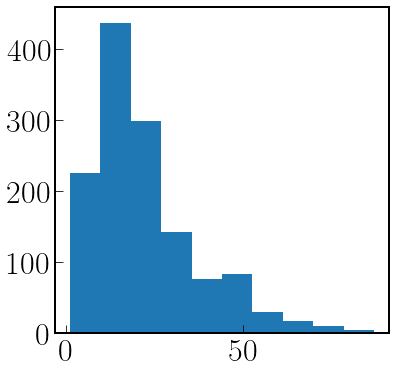

In [55]:
plt.hist(10**((g.int_average_g-0.63)/5-2))

In [57]:
v_sun = coord.Galactocentric.galcen_v_sun
def subtract(i):
    if i==int(i/1000)*1000:
        print(i,flush=True)
    t=g.iloc[i]
    c1 = SkyCoord(ra=t.ra*u.degree, dec=t.dec*u.degree, distance=t.Dkpc*u.kpc, pm_ra_cosdec=t.pmra*u.mas/u.year, pm_dec=t.pmdec*u.mas/u.year, radial_velocity=0*u.km/u.s, frame='icrs')
    c2 = c1.galactic
    rep = c2.cartesian.without_differentials()
    c3 = rep.with_differentials(c2.cartesian.differentials['s'] + v_sun)
    c4 = coord.Galactic(c3).transform_to(coord.ICRS)
    t1={'source_id': g.iloc[i,0]}
    t1.update({'pmra_cl_sm':c4.pm_ra_cosdec.value,\
            'pmdec_cl_sm':c4.pm_dec.value,\
            'l':c2.l.value,\
            'b':c2.b.value,\
            'pm_lcosb':c2.pm_l_cosb.value,\
            'pm_b':c2.pm_b.value,\
            'pm_lcosb_sm':coord.Galactic(c3).pm_l_cosb.value,\
            'pm_b_sm':coord.Galactic(c3).pm_b.value,\
            'galcen_x':c2.galactocentric.x.value,\
            'galcen_y':c2.galactocentric.y.value,\
            'galcen_z':c2.galactocentric.z.value,\
            'galcen_vx':c2.galactocentric.v_x.value,\
            'galcen_vy':c2.galactocentric.v_y.value,\
            'galcen_vz':c2.galactocentric.v_z.value})
    return t1

In [58]:
pool1=mp.Pool(20)
data1=pool1.map(subtract,range(len(g)))
pool1.close()

0
1000


In [59]:
l2=pd.DataFrame(data1)
l2=l2[['source_id','pmra_cl_sm','pmdec_cl_sm','l','b','pm_lcosb','pm_b','pm_lcosb_sm','pm_b_sm','galcen_x','galcen_y','galcen_z','galcen_vx','galcen_vy','galcen_vz']]
#l2.to_csv(pwd+'starall_sm_sub.csv',index=False)

In [60]:
l3=g.merge(l2, on='source_id')
l3['v_ra']=l3.Dkpc*l3.pmra/3600*3.261564*300000*np.pi/180
l3['v_dec']=l3.Dkpc*l3.pmdec/3600*3.261564*300000*np.pi/180
l3['v_b']=l3.Dkpc*l3.pm_b/3600*3.261564*300000*np.pi/180
l3['v_lcosb']=l3.Dkpc*l3.pm_lcosb/3600*3.261564*300000*np.pi/180
l3['v_ra_sm']=l3.Dkpc*l3.pmra_cl_sm/3600*3.261564*300000*np.pi/180
l3['v_dec_sm']=l3.Dkpc*l3.pmdec_cl_sm/3600*3.261564*300000*np.pi/180
l3['v_b_sm']=l3.Dkpc*l3.pm_b_sm/3600*3.261564*300000*np.pi/180
l3['v_lcosb_sm']=l3.Dkpc*l3.pm_lcosb_sm/3600*3.261564*300000*np.pi/180

In [61]:
g0=l3[(l3.ra<36)|(l3.ra>330)]

In [62]:
g2=l3[(l3.ra<36)]
g1=l3[(l3.ra>330)]

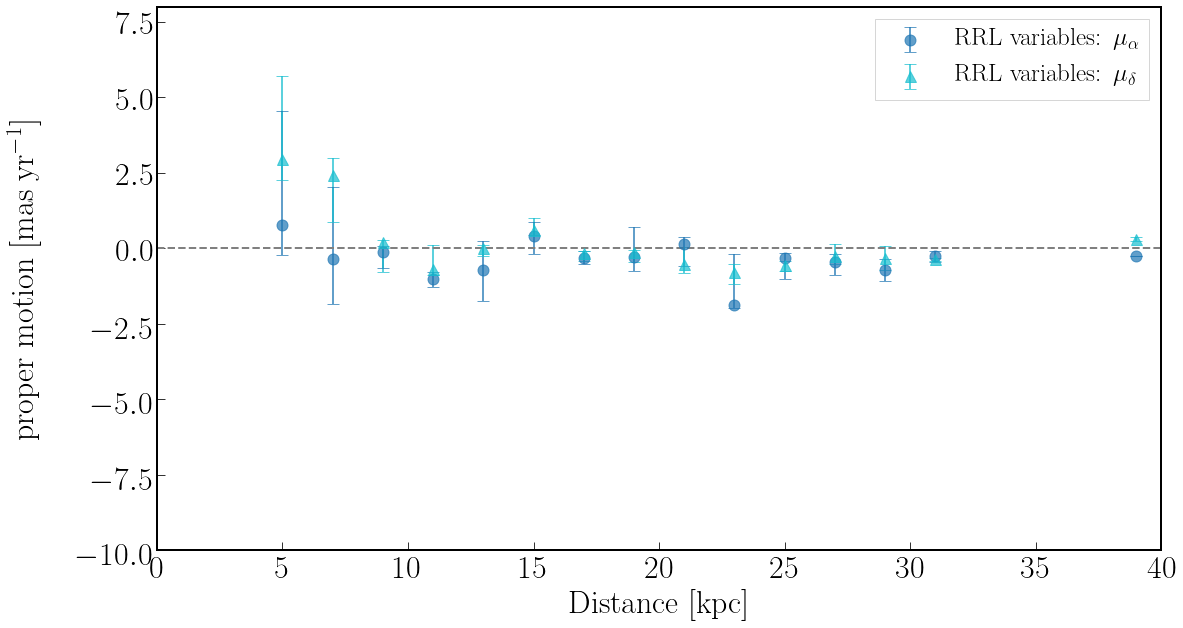

In [63]:
#D=10**((g0.phot_g_mean_mag-0.7)/5-2)
D=g0.Dkpc
ra=g0.ra
pmra = g0.pmra_cl_sm
pmdec = g0.pmdec_cl_sm
fig=plt.figure(figsize=(18,10))
ax=plt.subplot(111)
#ax.scatter(D, pmra, s=0.01, c='red', label='pmra')
#ax.scatter(D, pmdec, s=0.01, c='blue', label='pmdec')
ax.set_xlim(0,40)
ax.set_ylim(-10,8)
ax.set_xlabel('Distance [kpc]',fontsize=32)
ax.set_ylabel('proper motion [mas yr$^{-1}$]',fontsize=32,labelpad=35)
x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmra, 0, 40, 20, 0)
x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 0, 40, 20, 0)
ax.errorbar(x1Bin, m1edianBin, s1igGbin, fmt='o',c='tab:blue',capsize=6, markersize=11,alpha=0.7, label=r'RRL variables: $\mu_\alpha$')
ax.errorbar(x2Bin, m2edianBin, s2igGbin, fmt='^',c='tab:cyan',capsize=6, markersize=11,alpha=0.7, label=r'RRL variables: $\mu_\delta$')
'''
D=10**((g2.phot_g_mean_mag-0.7)/5-2)
ra=g2.ra
pmra = g2.pmra
pmdec = g2.pmdec
x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmra, 0, 40, 20, 0)
x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 0, 40, 20, 0)
ax.errorbar(x1Bin, m1edianBin, s1igGbin, fmt='o',c='tab:blue',capsize=6, markersize=11,alpha=0.7,markerfacecolor='white', label=r'RRL variables with Sgr. Stream: $\mu_\alpha$')
ax.errorbar(x2Bin, m2edianBin, s2igGbin, fmt='^',c='tab:cyan',capsize=6, markersize=11,alpha=0.7, markerfacecolor='white',label=r'RRL variables with Sgr. Stream: $\mu_\delta$')


'''
xL = np.linspace(0,400)
ax.plot(xL, 0*xL+0.00, linestyle='dashed',c='grey')
#plt.title('proper motion vs. distance for blue stars')
plt.legend()
#plt.savefig('../Documents/final/1/dblue.pdf')
#plt.savefig('../Documents/final/test/RRL1.pdf')

In [74]:
ms=pd.read_csv('../Downloads/catalog/final/4/starall_sm.csv')

In [75]:
mb=ms[ms.gr<0.6]
mr=ms[ms.gr>0.6]

In [76]:
mb1=mb[mb.i_sdsscentroid_ra<0]
mb2=mb[mb.i_sdsscentroid_ra>0]
mr1=mr[mr.i_sdsscentroid_ra<0]
mr2=mr[mr.i_sdsscentroid_ra>0]

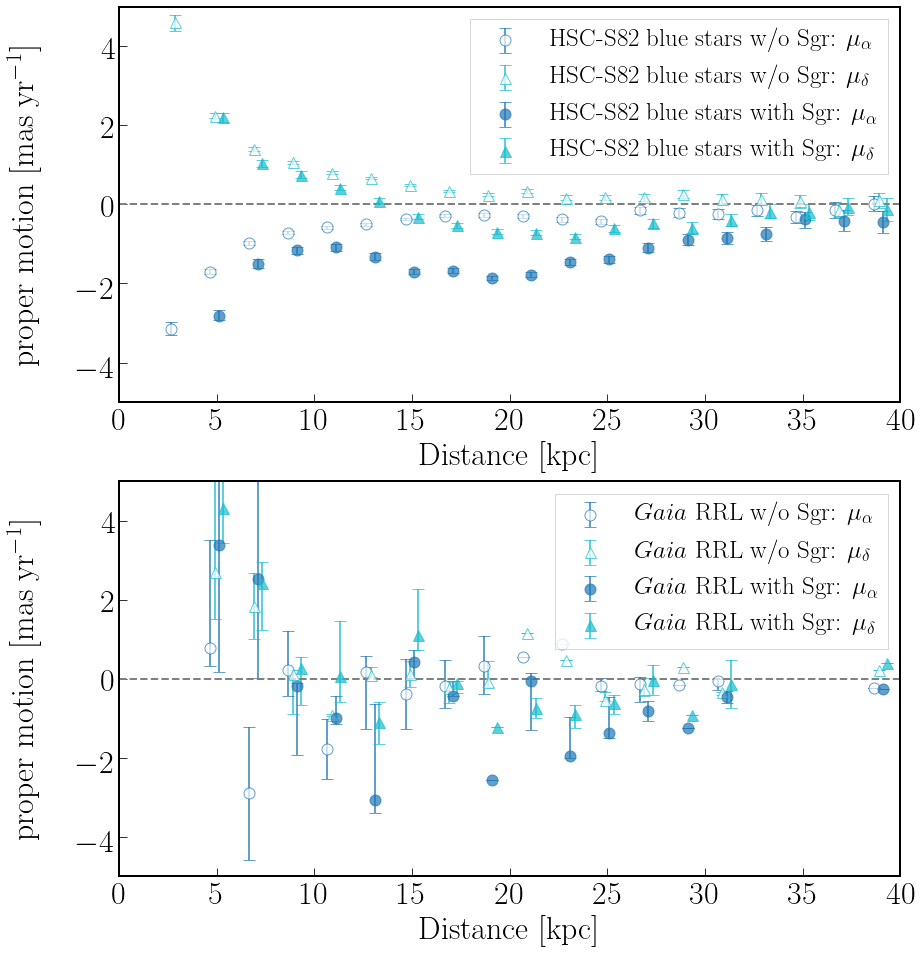

In [71]:

fig=plt.figure(figsize=(14,16))
ax=plt.subplot(211)
ax.set_xlim(0,40)
ax.set_ylim(-5,5)
ax.set_xlabel('Distance [kpc]',fontsize=32)
ax.set_ylabel('proper motion [mas yr$^{-1}$]',fontsize=32,labelpad=35)
D=mb1.Dkpc
ra=mb1.i_sdsscentroid_ra
pmra = mb1.pmra_cl_sm
pmdec = mb1.pmdec_cl_sm
x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmra, 0, 40, 20, 0)
x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 0, 40, 20, 0)
ax.errorbar(x1Bin-0.33, m1edianBin, s1igGbin, fmt='o',c='tab:blue',capsize=6, markersize=11,alpha=0.7,markerfacecolor='white', label=r'HSC-S82 blue stars w/o Sgr: $\mu_\alpha$')
ax.errorbar(x2Bin-0.11, m2edianBin, s2igGbin, fmt='^',c='tab:cyan',capsize=6, markersize=11,alpha=0.7,markerfacecolor='white', label=r'HSC-S82 blue stars w/o Sgr: $\mu_\delta$')

#D=10**((g2.phot_g_mean_mag-0.7)/5-2)
D=mb2.Dkpc
ra=mb2.i_sdsscentroid_ra
pmra = mb2.pmra_cl_sm
pmdec = mb2.pmdec_cl_sm
x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmra, 0, 40, 20, 0)
x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 0, 40, 20, 0)
ax.errorbar(x1Bin+0.11, m1edianBin, s1igGbin, fmt='o',c='tab:blue',capsize=6, markersize=11,alpha=0.7, label=r'HSC-S82 blue stars with Sgr: $\mu_\alpha$')
ax.errorbar(x2Bin+0.33, m2edianBin, s2igGbin, fmt='^',c='tab:cyan',capsize=6, markersize=11,alpha=0.7, label=r'HSC-S82 blue stars with Sgr: $\mu_\delta$')
xL = np.linspace(0,400)
ax.plot(xL, 0*xL+0.00, linestyle='dashed',c='grey')
#plt.title('proper motion vs. distance for blue stars')
plt.legend()



ax=plt.subplot(212)
#ax.scatter(D, pmra, s=0.01, c='red', label='pmra')
#ax.scatter(D, pmdec, s=0.01, c='blue', label='pmdec')
ax.set_xlim(0,40)
ax.set_ylim(-5,5)
ax.set_xlabel('Distance [kpc]',fontsize=32)
ax.set_ylabel('proper motion [mas yr$^{-1}$]',fontsize=32,labelpad=35)
#D=10**((g1.phot_g_mean_mag-0.7)/5-2)
D=g1.Dkpc
ra=g1.ra
pmra = g1.pmra_cl_sm
pmdec = g1.pmdec_cl_sm
x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmra, 0, 40, 20, 0)
x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 0, 40, 20, 0)
ax.errorbar(x1Bin-0.33, m1edianBin, s1igGbin, fmt='o',c='tab:blue',capsize=6, markersize=11,alpha=0.7,markerfacecolor='white', label=r'$Gaia$ RRL w/o Sgr: $\mu_\alpha$')
ax.errorbar(x2Bin-0.11, m2edianBin, s2igGbin, fmt='^',c='tab:cyan',capsize=6, markersize=11,alpha=0.7,markerfacecolor='white', label=r'$Gaia$ RRL w/o Sgr: $\mu_\delta$')

#D=10**((g2.phot_g_mean_mag-0.7)/5-2)
D=g2.Dkpc
ra=g2.ra
pmra = g2.pmra_cl_sm
pmdec = g2.pmdec_cl_sm
x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmra, 0, 40, 20, 0)
x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 0, 40, 20, 0)
ax.errorbar(x1Bin+0.11, m1edianBin, s1igGbin, fmt='o',c='tab:blue',capsize=6, markersize=11,alpha=0.7, label=r'$Gaia$ RRL with Sgr: $\mu_\alpha$')
ax.errorbar(x2Bin+0.33, m2edianBin, s2igGbin, fmt='^',c='tab:cyan',capsize=6, markersize=11,alpha=0.7, label=r'$Gaia$ RRL with Sgr: $\mu_\delta$')



xL = np.linspace(0,400)
ax.plot(xL, 0*xL+0.00, linestyle='dashed',c='grey')
#plt.title('proper motion vs. distance for blue stars')
plt.legend()
#plt.savefig('../Documents/final/1/dblue.pdf')
plt.savefig('../Documents/final/test/RRL_sm.pdf')